In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Google Drive 마운트해서 데이터셋 가져옴

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# ROOT_DIR, DATA_ROOT_DIR 설정

In [3]:
import os

ROOT_DIR = '/content'
DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'Dataset_BUSI_with_GT')
CLASSIFICATION_DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'Classification')
CLASSIFICATION_TRAIN_DATA_ROOT_DIR = os.path.join(CLASSIFICATION_DATA_ROOT_DIR, 'train')

In [4]:
import shutil

if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)

if os.path.exists(CLASSIFICATION_DATA_ROOT_DIR):
    shutil.rmtree(CLASSIFICATION_DATA_ROOT_DIR)

# Google Drive 에서 dataset download

In [5]:
import shutil
import os

try:
    dataset_path = '/content/gdrive/My Drive/Colab Notebooks/dataset'
    shutil.copy(os.path.join(dataset_path, 'Dataset_BUSI_with_GT.zip'), '/content')

except Exception as err:
    print(str(err))

In [6]:
import zipfile

with zipfile.ZipFile(os.path.join(ROOT_DIR, 'Dataset_BUSI_with_GT.zip'), 'r') as target_file:
    target_file.extractall(DATA_ROOT_DIR)

In [7]:
import shutil
import os
import glob

total_file_list = glob.glob(os.path.join(DATA_ROOT_DIR, '*'))
label_name_list = [ file_name.split('/')[-1].strip()  for file_name in total_file_list  if os.path.isdir(file_name) == True ]

if not os.path.exists(CLASSIFICATION_DATA_ROOT_DIR):
    os.mkdir(CLASSIFICATION_DATA_ROOT_DIR)

for label_name in label_name_list:
    src_dir_path = os.path.join(DATA_ROOT_DIR, label_name)
    dst_dir_path = os.path.join(CLASSIFICATION_DATA_ROOT_DIR,
                                'train'+'/'+label_name)
    try:
        shutil.copytree(src_dir_path, dst_dir_path)
    except Exception as err:
        print(str(err))

train_label_name_list = os.listdir(CLASSIFICATION_TRAIN_DATA_ROOT_DIR)

for label_name in train_label_name_list:
    print('train label : ', label_name,' => ', len(os.listdir(os.path.join(CLASSIFICATION_TRAIN_DATA_ROOT_DIR, label_name))))

train label :  Dataset_BUSI_with_GT  =>  3


#### Classification 데이터 생성

In [8]:
import os

if not os.path.exists(CLASSIFICATION_DATA_ROOT_DIR):
    os.mkdir(CLASSIFICATION_DATA_ROOT_DIR)

In [9]:
#========================================================
# copytree 이용해서 정답이름/images 디렉토리를
# train/정답이름 으로 복사함
#========================================================

for label_name in label_name_list:
    src_dir_path = os.path.join(DATA_ROOT_DIR, label_name)
    dst_dir_path = os.path.join(CLASSIFICATION_DATA_ROOT_DIR, 'train'+'/'+label_name)

    try:
        shutil.copytree(src_dir_path, dst_dir_path)
        print(label_name+' copytree is done !!')

    except Exception as err:
        print(str(err))

[Errno 17] File exists: '/content/Classification/train/Dataset_BUSI_with_GT'


In [10]:
import os

#========================================================
# Classification 위한 train 정답 및 전체 데이터 개수 확인
# 현재는 image 와 mask 함께 존재하고 있음
#========================================================

train_label_name_list = os.listdir(CLASSIFICATION_TRAIN_DATA_ROOT_DIR)

for label_name in train_label_name_list:
    print('train label : ', label_name,' => ', len(os.listdir(os.path.join(CLASSIFICATION_TRAIN_DATA_ROOT_DIR, label_name))))

train label :  Dataset_BUSI_with_GT  =>  3


In [11]:
import os
import glob
import pandas as pd

train_label_name_list = os.listdir(CLASSIFICATION_TRAIN_DATA_ROOT_DIR)

for label_name in train_label_name_list:
    temp_dic = {}
    file_list = glob.glob(CLASSIFICATION_TRAIN_DATA_ROOT_DIR+'/'+label_name+'/*')
    temp_dic[label_name] = file_list    # temp_dic['label_name'] = [ file_name, ... ]
    temp_df = pd.DataFrame(temp_dic)
    image_file_df = temp_df[~temp_df[label_name].str.contains('_mask')].reset_index(drop=True)
    mask_file_df = temp_df[temp_df[label_name].str.contains('_mask')].reset_index(drop=True)
    print('label = ', label_name, ' , image  = ', len(image_file_df), ' , mask = ', len(mask_file_df))

    for row in range(len(mask_file_df)):
        try:
            os.remove(mask_file_df.loc[row,label_name])
        except Exception as err:
            print(str(err))

label =  Dataset_BUSI_with_GT  , image  =  3  , mask =  0


# Classification 에서 Data Augmentation 하기 위한 전체 데이터 개수 계산

In [12]:
import os

train_label_name_list = os.listdir(CLASSIFICATION_TRAIN_DATA_ROOT_DIR)
total_image_data_nums = 0

for label_name in train_label_name_list:    # 각각의 정답(label)에 대해서
    image_data_nums = len(os.listdir(os.path.join(CLASSIFICATION_TRAIN_DATA_ROOT_DIR, label_name)))
    print('label = ', label_name, ' , data nums = ', image_data_nums)
    total_image_data_nums += image_data_nums

print('total image data nums = ', total_image_data_nums)

label =  Dataset_BUSI_with_GT  , data nums =  3
total image data nums =  3


In [13]:
TOTAL_TRAIN_IMAGE_DATA_NUMS = total_image_data_nums

In [14]:
original_gen = ImageDataGenerator(rescale=1./255)

original_generator = original_gen.flow_from_directory(CLASSIFICATION_TRAIN_DATA_ROOT_DIR,
                                   batch_size=TOTAL_TRAIN_IMAGE_DATA_NUMS, shuffle=False,
                                   target_size=(224, 224), class_mode='sparse')

Found 1578 images belonging to 1 classes.


In [15]:
x_train, y_train = original_generator.next()

print(x_train.shape, y_train.shape)

(3, 224, 224, 3) (3,)


#### Augmentation Data 생성

In [16]:
AUGMENTATION_COUNT = 4    # 원본 데이터의 4배 증대

In [17]:
augmentation_gen = ImageDataGenerator(rescale=1./255, rotation_range=10, shear_range=0.1, zoom_range=0.1,
                                      horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1)

augmentation_generator = augmentation_gen.flow_from_directory(CLASSIFICATION_TRAIN_DATA_ROOT_DIR,
                                   batch_size=TOTAL_TRAIN_IMAGE_DATA_NUMS, shuffle=False,
                                   target_size=(224, 224), class_mode='sparse')

Found 1578 images belonging to 1 classes.


In [18]:
import numpy as np

print('====================================================')
print('[bofore] ', x_train.shape, y_train.shape)
print('====================================================')

for i in range(AUGMENTATION_COUNT):    # 780개의 전체 데이터에 대해서 AUGMENTATION_COUNT 배 AUGMENTATION 실행
    x_augmented, y_augmented = augmentation_generator.next()
    x_train = np.concatenate( (x_train, x_augmented) )
    y_train = np.concatenate( (y_train, y_augmented) )

print('[after] ', x_train.shape, y_train.shape)
print('====================================================')

[bofore]  (3, 224, 224, 3) (3,)
[after]  (15, 224, 224, 3) (15,)


# train data random shuffle

In [19]:
s = np.arange(x_train.shape[0])

np.random.shuffle(s)

x_train = x_train[s]
y_train = y_train[s]

In [20]:
SPLIT_RATIO = 0.2    # train : test = 8 : 2

In [21]:
split_num = int(SPLIT_RATIO*(x_train.shape[0]))

x_test = x_train[:split_num]
y_test = y_train[:split_num]

print(x_test.shape, y_test.shape)

(3, 224, 224, 3) (3,)


In [22]:
x_train = x_train[split_num:]
y_train = y_train[split_num:]

print(x_train.shape, y_train.shape)

(12, 224, 224, 3) (12,)


# 16 개의 데이터와 정답 출력

IndexError: ignored

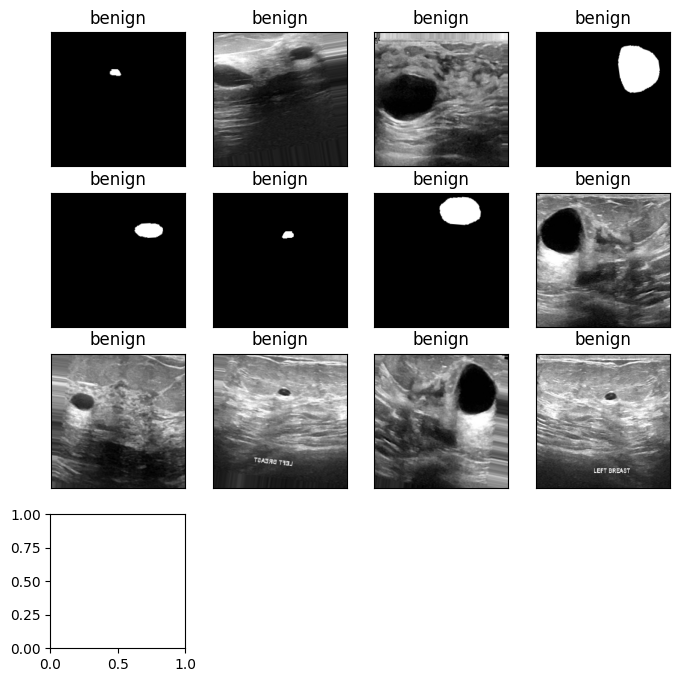

In [23]:
import matplotlib.pyplot as plt

class_dict = {0:'benign', 1:'malignant', 2:'normal'}

plt.figure(figsize=(8,8))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title(str(class_dict[int(y_train[i])]))
    plt.xticks([])
    plt.yticks([])

    plt.imshow(x_train[i])

plt.tight_layout()
plt.show()

# IMAGE SHAPE 설정

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

# Fine Tuning 위한 pre-trained model 정의 및 모델 구축

In [ ]:
class_nums = original_generator.num_classes

pre_trained_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))

model = Sequential()
model.add(pre_trained_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(class_nums, activation='softmax'))

model.summary()

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['acc'])

In [ ]:
hist = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test))

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
model.evaluate(x_test, y_test)